#  Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d16bd5cdbe4e2eda5c5310792f999254e04a4cc7d230d39d03c9bf8bc4ff9dc5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=71b29dec88fb445ae388585b289d671c75c5b74df7a08bc351b615a412c77d6a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [5]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'

EPOCHS=50
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16

ENCODER='efficientnet-b0'
WEIGHTS='imagenet'

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
train_df,test_df=train_test_split(df, test_size=0.2, random_state=0)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A
from torchvision import transforms

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE)

  ],is_check_shapes=False)

def Demons_aug():
    return transforms.Compose([
      transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image
      transforms.ToTensor(),                       # Convert to Tensor
      transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize to [-1, 1]
    ])


#  Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask, axis=-1)# Adding 1 dim to mask (H,W,C)


    if self.augmentations:
      data=self.augmentations(image=image,mask= mask)
      image=data['image']
      mask=data['mask']

  # (H,W,C)->(C,H,W)
    image=np.transpose(image, (2,0,1)).astype(np.float32)
    mask=np.transpose(mask, (2,0,1)).astype(np.float32)

    image=torch.tensor(image)/255.0
    mask=torch.round(torch.tensor(mask)/255.0)

    return image, mask

In [14]:
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")


Image shape: (195, 259, 3), Mask shape: (195, 259)


In [15]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(test_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


(torch.Size([3, 320, 320]), torch.Size([1, 320, 320]))

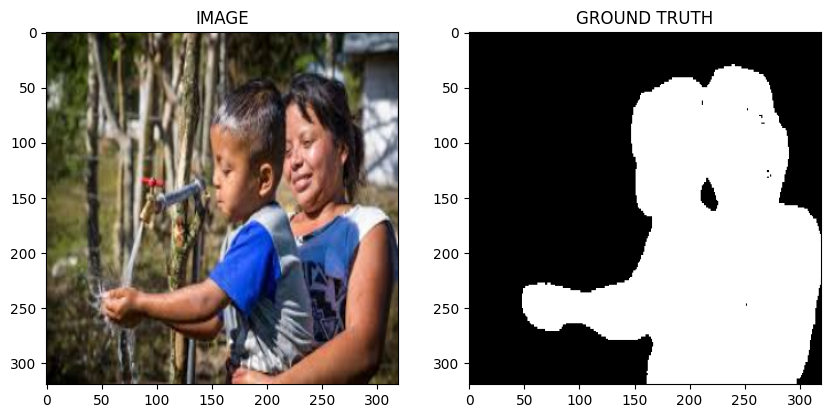

In [17]:
idx=5
image,mask = trainset[idx]

helper.show_image(image, mask)
image.shape, mask.shape

#  Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f"total no of batches in trainloader : {len(trainloader)}")
print(f"total no of batches in validloader : {len(validloader)}" )

total no of batches in trainloader : 15
total no of batches in validloader : 4


In [21]:
for image, mask in trainloader:
  print(f"image shape : {image.shape}")
  print(f"mask shape : {mask.shape}")
  break

image shape : torch.Size([16, 3, 320, 320])
mask shape : torch.Size([16, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.losses import DiceLoss

In [23]:
class segmentationModel(nn.Module):
  def __init__(self):
    super(segmentationModel, self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images, mask=None):
    logits=self.arc(images)

    if mask!=None:
      loss1=DiceLoss(mode='binary')(logits,mask)
      loss2=nn.BCEWithLogitsLoss()(logits,mask)
      return logits, loss1+loss2

    return logits





In [24]:
model=segmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 98.9MB/s]


segmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

# Create Train and Validation Function

In [25]:
def train_fn(data_loader,model,optimizer):


  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    images=images.to(DEVICE,dtype=torch.float32)
    masks=masks.to(DEVICE,dtype=torch.float32)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)

In [26]:
def eval_fn(data_loader,model):


  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):

      images=images.to(DEVICE,dtype=torch.float32)
      masks=masks.to(DEVICE,dtype=torch.float32)

      logits,loss=model(images,masks)

      total_loss+=loss.item()

    return total_loss/len(data_loader)

# Train Model

In [65]:
optimizer= torch.optim.Adam(model.parameters(), lr=LR)

In [66]:
best_valid_loss=np.inf

for i in range(EPOCHS):

  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved Best Model!')
    best_valid_loss=valid_loss
  print(f"Epoch: {i+1} Train loss: {train_loss} Valid_loss: {valid_loss}")
torch.save(model.state_dict(), 'Last_model.pt')
print('Saved Last Model!')

100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Saved Best Model!
Epoch: 1 Train loss: 0.13883519570032757 Valid_loss: 0.2530238702893257


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch: 2 Train loss: 0.15620270868142447 Valid_loss: 0.34469757974147797


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch: 3 Train loss: 0.11173910001913706 Valid_loss: 0.30877769365906715


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Saved Best Model!
Epoch: 4 Train loss: 0.11530532340208689 Valid_loss: 0.20206394791603088


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Saved Best Model!
Epoch: 5 Train loss: 0.10214073409636816 Valid_loss: 0.1952560842037201


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Saved Best Model!
Epoch: 6 Train loss: 0.09234956900278728 Valid_loss: 0.1556142009794712


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch: 7 Train loss: 0.08503226141134898 Valid_loss: 0.16261806525290012


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Saved Best Model!
Epoch: 8 Train loss: 0.08469715168078741 Valid_loss: 0.15407974645495415


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch: 9 Train loss: 0.09486168424288431 Valid_loss: 0.1878755148500204


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch: 10 Train loss: 0.08479908555746078 Valid_loss: 0.15937019512057304


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Saved Best Model!
Epoch: 11 Train loss: 0.08068858335415523 Valid_loss: 0.13483303040266037


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Saved Best Model!
Epoch: 12 Train loss: 0.09677688876787821 Valid_loss: 0.13233786448836327


100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch: 13 Train loss: 0.09828180422385534 Valid_loss: 0.25031615048646927


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch: 14 Train loss: 0.133943239847819 Valid_loss: 0.20752161741256714


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch: 15 Train loss: 0.09859601159890492 Valid_loss: 0.20048029348254204


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch: 16 Train loss: 0.08820468684037526 Valid_loss: 0.1816241592168808


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch: 17 Train loss: 0.08415606195727984 Valid_loss: 0.1615540310740471


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch: 18 Train loss: 0.10059212148189545 Valid_loss: 0.23796699568629265


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch: 19 Train loss: 0.09681584189335506 Valid_loss: 0.2643117941915989


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Epoch: 20 Train loss: 0.09350590457518895 Valid_loss: 0.3721877336502075


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch: 21 Train loss: 0.08500800927480062 Valid_loss: 0.23668649792671204


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch: 22 Train loss: 0.08294456973671913 Valid_loss: 0.21387715637683868


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch: 23 Train loss: 0.0816899890700976 Valid_loss: 0.21815624088048935


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch: 24 Train loss: 0.08093906665841738 Valid_loss: 0.16550885140895844


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch: 25 Train loss: 0.08482828761140505 Valid_loss: 0.16148114204406738


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch: 26 Train loss: 0.07831560522317886 Valid_loss: 0.16977442614734173


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch: 27 Train loss: 0.07352210233608882 Valid_loss: 0.13772586733102798


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch: 28 Train loss: 0.06587244595090548 Valid_loss: 0.1341278925538063


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Saved Best Model!
Epoch: 29 Train loss: 0.06377870092789333 Valid_loss: 0.12240608967840672


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch: 30 Train loss: 0.07432707001765569 Valid_loss: 0.16858465038239956


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch: 31 Train loss: 0.07013438815871874 Valid_loss: 0.1483377404510975


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch: 32 Train loss: 0.06562349696954091 Valid_loss: 0.13868622668087482


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch: 33 Train loss: 0.06133479848504066 Valid_loss: 0.1352663952857256


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch: 34 Train loss: 0.06372337515155474 Valid_loss: 0.1329342294484377


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch: 35 Train loss: 0.06598170474171638 Valid_loss: 0.13301401771605015


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch: 36 Train loss: 0.06853785663843155 Valid_loss: 0.12453943490982056


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch: 37 Train loss: 0.0669516218205293 Valid_loss: 0.15207037143409252


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch: 38 Train loss: 0.09250191176931064 Valid_loss: 0.23122928850352764


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch: 39 Train loss: 0.08086065327127774 Valid_loss: 0.19375508651137352


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch: 40 Train loss: 0.0660118800898393 Valid_loss: 0.26172914914786816


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch: 41 Train loss: 0.0635359339416027 Valid_loss: 0.21459368988871574


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch: 42 Train loss: 0.07032636751731237 Valid_loss: 0.2123943492770195


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch: 43 Train loss: 0.06398077284296354 Valid_loss: 0.1512383446097374


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch: 44 Train loss: 0.07856743633747101 Valid_loss: 0.19504136219620705


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch: 45 Train loss: 0.0763070782025655 Valid_loss: 0.18285315670073032


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch: 46 Train loss: 0.07237918376922607 Valid_loss: 0.12935037538409233


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch: 47 Train loss: 0.06409108514587085 Valid_loss: 0.1771115455776453


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch: 48 Train loss: 0.056741677969694135 Valid_loss: 0.15558921359479427


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch: 49 Train loss: 0.06063727860649427 Valid_loss: 0.1367019470781088


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Saved Best Model!
Epoch: 50 Train loss: 0.055401940395434696 Valid_loss: 0.11872916482388973
Saved Last Model!


# Inference

In [73]:
idx=36

model.load_state_dict(torch.load('/content/Last_model.pt'))

image, mask = validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))#(C,W,H)->(1,C,W,H)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

<ipython-input-73-22137a0a220e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/Last_model.pt'))


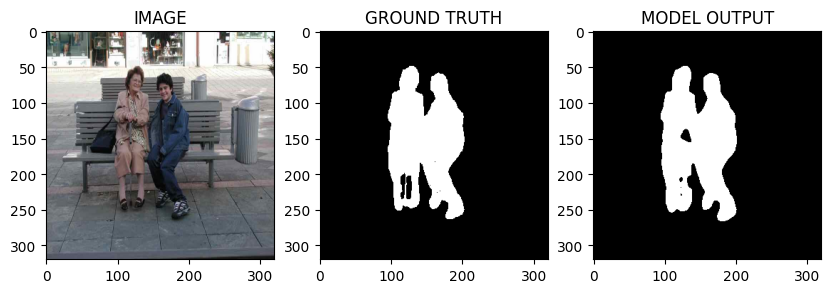

In [74]:
helper.show_image(image, mask,pred_mask.detach().cpu().squeeze(0))

##Input the Image

Saving 1 (1).jpg to 1 (1).jpg
Uploaded file: 1 (1).jpg


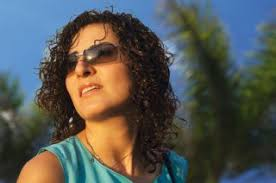

In [81]:
from google.colab.patches import cv2_imshow
from google.colab import files
import cv2

# Upload the image
uploaded = files.upload()

# Extract the filename from the uploaded dictionary
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")

    photo = cv2.imread(file_name)
    if photo is None:
        print("Failed to read the image. Ensure the file is an image.")
        continue

    cv2_imshow(photo)


#Predict the Mask

In [82]:
from PIL import Image
transform=Demons_aug()
photo = np.array(photo)

# Convert the NumPy array to a PIL image
photo_pil = Image.fromarray(photo)

im=transform(photo_pil)
im=im.unsqueeze(0)

#predict the mask

logits_mask=model(im.to(DEVICE))#(C,W,H)->(1,C,W,H)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

##Visualize the Input(Image) and Output(Mask)

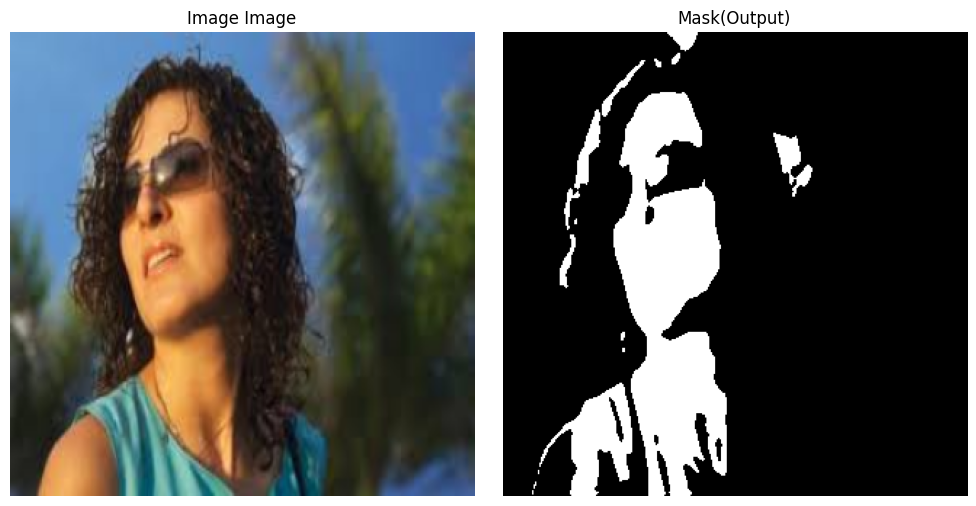

In [83]:
import torch
import matplotlib.pyplot as plt

image_np = pred_mask.detach().cpu().squeeze().numpy()
photo1=cv2.resize(photo,((320,320)))
photo_rgb = cv2.cvtColor(photo1, cv2.COLOR_RGB2BGR)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(photo_rgb)
axes[0].set_title("Image Image")
axes[0].axis('off')  # Optional: Hide axes for a cleaner view

axes[1].imshow(image_np,cmap='gray')
axes[1].set_title("Mask(Output)")
axes[1].axis('off')  # Optional: Hide axes for a cleaner view

plt.tight_layout()
plt.show()
